In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from somperf.metrics import *
from somperf.utils.topology import rectangular_topology_dist

import optuna
import numpy as np

d:\Kuliah\JST\Neural-Network-Final-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('dataset.xlsx', sheet_name='Sheet1') 
data = df.iloc[:,:-1]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656 entries, 0 to 5655
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   meanR   5656 non-null   float64
 1   meanG   5656 non-null   float64
 2   meanB   5656 non-null   float64
 3   stdR    5656 non-null   float64
 4   stdG    5656 non-null   float64
 5   stdB    5656 non-null   float64
 6   skewR   5656 non-null   float64
 7   skewG   5656 non-null   float64
 8   skewB   5656 non-null   float64
 9   kurR    5656 non-null   float64
 10  kurG    5656 non-null   float64
 11  kurB    5656 non-null   float64
 12  entR    5656 non-null   float64
 13  entG    5656 non-null   float64
 14  entB    5656 non-null   float64
dtypes: float64(15)
memory usage: 662.9 KB


###Preprocessing

In [4]:
#Standarization
scaler = StandardScaler()

df_scaled = scaler.fit_transform(data.copy())
df_scaled = pd.DataFrame(df_scaled, columns=data.columns)

df_scaled.head(3)

,meanR,meanG,meanB,stdR,stdG,stdB,skewR,skewG,skewB,kurR,kurG,kurB,entR,entG,entB
0,-0.665102,0.008693,-0.644699,-0.957046,-0.074790,-0.358296,-0.280260,-0.336533,0.694148,-0.275050,-0.357389,0.413462,0.260530,0.270445,-1.030791
1,-0.731039,-0.226412,-0.811958,-0.894219,-0.183617,-0.720664,0.071609,0.002909,0.695626,0.022708,-0.088418,0.532731,-0.107272,-0.118157,-1.012572
2,-0.178144,-0.392545,-0.305512,-0.087327,-0.407671,-0.370002,0.016748,0.039301,0.182180,-0.090864,-0.068511,0.161766,-0.205810,-0.210945,0.042868


In [5]:
#Split Dataset
X = df_scaled
y = df['Class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
y_train.unique()


array([5, 4, 2, 1, 6, 3])

###Dimension Reduction

In [7]:
#Dimension Reduction PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

In [8]:
def plot_dimension(data):
    plt.figure(figsize=(16, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=y_train, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(1, 7), label='Class')
    plt.title("Visualization of Classes")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

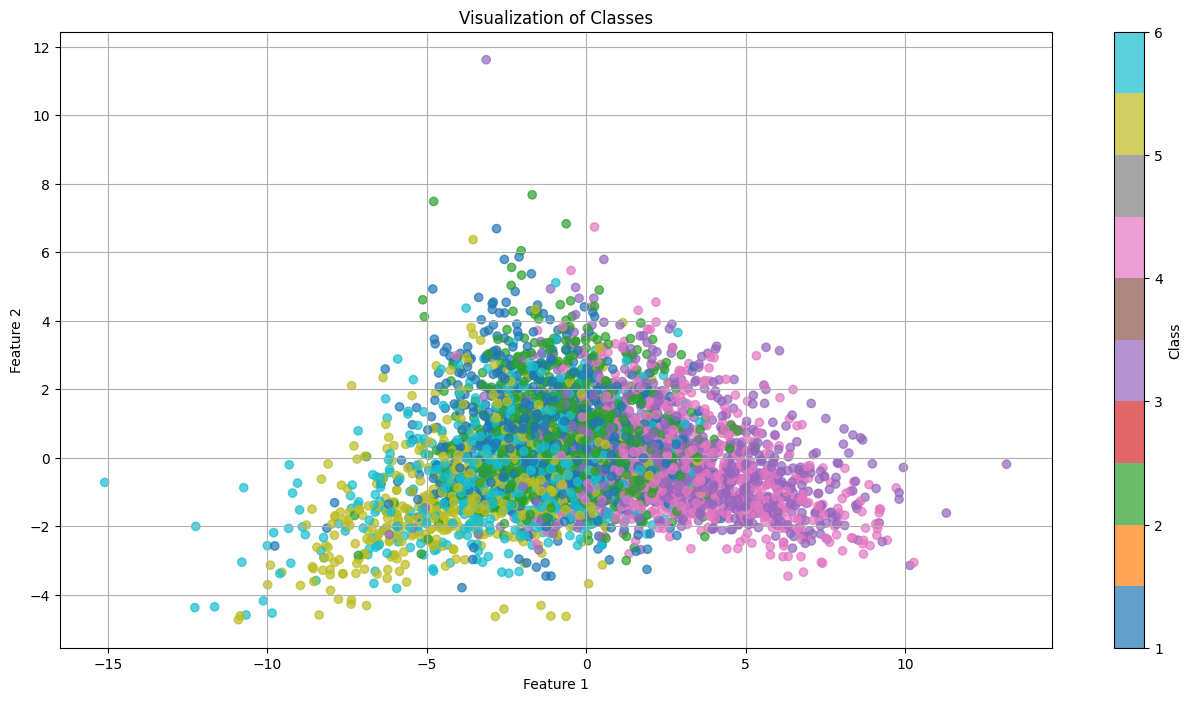

In [9]:
plot_dimension(X_pca)

###Building Model

In [10]:
class SOMlinier:
    def __init__(self, m, fitur, R, alpha, tau):
        self.m = m 
        self.fitur = fitur 
        self.w = np.random.rand(m, fitur) 
        self.R0 = R 
        self.alpha0 = alpha
        self.tau = tau
    
    def hitung_bmu(self, x):
        D = np.linalg.norm(self.w - x, axis=1)
        return np.argmin(D)
    
    def hitung_second_bmu(self, x):
        D = np.linalg.norm(self.w - x, axis=1)
        return np.argsort(D)[1]
    
    def update_bobot(self, x, j, R, alpha):
        for i in range(self.m):
            jarak = abs(i - j)
            if jarak <= R:
                influence = np.exp(-jarak**2 / (2 * (R**2)))
                self.w[i] += alpha * influence * (x - self.w[i])
    
    def kurangi_radius(self, iterasi):
        return self.R0 * np.exp(-iterasi / self.tau)

    def kurangi_learning_rate(self, iterasi):
        return self.alpha0 * np.exp(-iterasi / self.tau)

    def train(self, data, n_iterasi):
        for t in range(n_iterasi):
            x = data[np.random.randint(0, len(data))]
            j = self.hitung_bmu(x)
            R = self.kurangi_radius(t)
            alpha = self.kurangi_learning_rate(t)
            self.update_bobot(x, j, R, alpha)

    def quantization_error(self, data):
        total_error = np.mean([np.linalg.norm(x - self.w[self.hitung_bmu(x)]) for x in data])
        return total_error
    
    def topographic_error(self, data):
        errors = 0
        for x in data:
            bmu = self.hitung_bmu(x)
            second_bmu = self.hitung_second_bmu(x)
            if abs(bmu - second_bmu) > 1:
                errors += 1
        te = errors / len(data)
        return te

In [41]:
# Dengan PCA
m = 10      
fitur = 2
R = 4  
alpha0 = 0.11910072554906094          
tau = 584             
n_iterations = 930  

# Initialize the SOM
som_pca = SOMlinier(m=m, fitur=fitur, R=R, alpha=alpha0, tau=tau)

# Train the SOM with the PCA-reduced dataset
som_pca.train(X_pca, n_iterations)

# After training, you can access the SOM weights with:
weights_pca = som_pca.w
print("Trained SOM weights:", weights_pca)

Trained SOM weights: [[-5.14722013 -1.12242377]
 [-3.43255625 -0.41432766]
 [-1.87965905 -0.69642665]
 [-1.24122773  0.20498519]
 [-1.04402737  1.59617387]
 [ 0.13211886  1.48731955]
 [ 1.28854568  0.38343322]
 [ 2.47875557 -0.36739811]
 [ 3.99500589 -0.61200469]
 [ 5.70376195 -0.77473944]]


C:\Users\lmaos\AppData\Local\Temp\ipykernel_14508\180264103.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices_pca))  # Colormap 'tab10' untuk warna berbeda


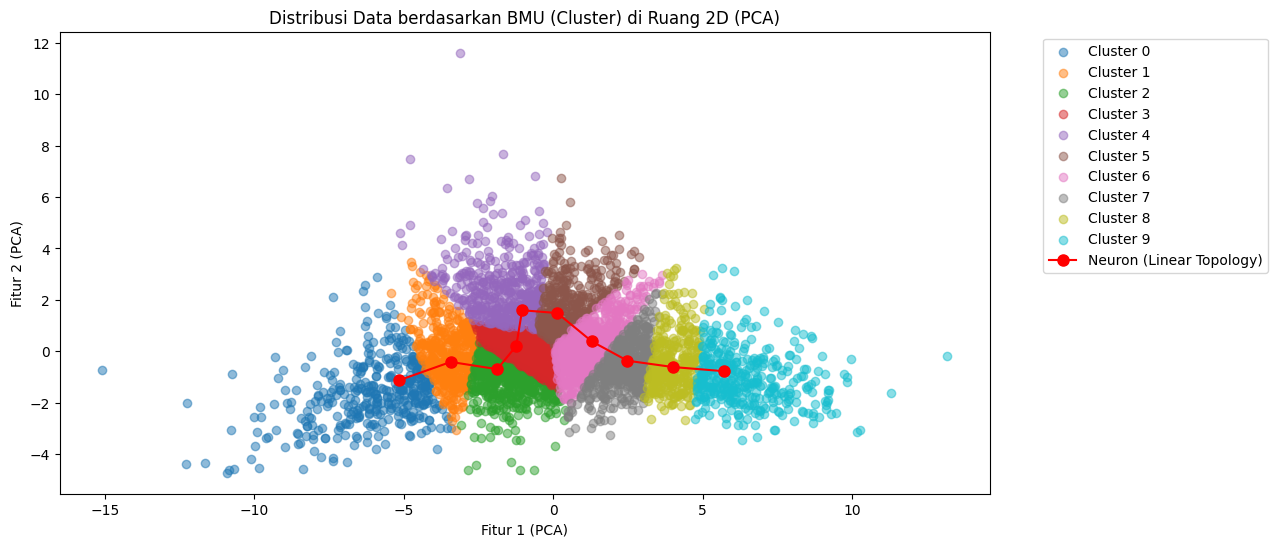

In [46]:
# Melakukan PCA ke 2D untuk visualisasi

# Hitung BMU untuk setiap titik data dalam hasil PCA
bmu_indices_pca = np.array([som_pca.hitung_bmu(x) for x in X_pca])

# Buat scatter plot dengan warna berbeda untuk setiap BMU berdasarkan hasil PCA
plt.figure(figsize=(12, 6))

# Loop untuk setiap BMU unik
unique_bmu_indices_pca = np.unique(bmu_indices_pca)
colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices_pca))  # Colormap 'tab10' untuk warna berbeda

for i, bmu in enumerate(unique_bmu_indices_pca):
    # Filter data yang termasuk dalam BMU saat ini
    cluster_data_pca = X_pca[bmu_indices_pca == bmu]
    plt.scatter(cluster_data_pca[:, 0], cluster_data_pca[:, 1], label=f'Cluster {bmu}', color=colors(i), alpha=0.5)

# Plot neuron dalam topologi linier untuk PCA sebagai titik merah
plt.plot(weights_pca[:, 0], weights_pca[:, 1], 'r-o', label="Neuron (Linear Topology)", markersize=8)

plt.title("Distribusi Data berdasarkan BMU (Cluster) di Ruang 2D (PCA)")
plt.xlabel("Fitur 1 (PCA)")
plt.ylabel("Fitur 2 (PCA)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [47]:
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Variance Explained:", sum(pca.explained_variance_ratio_))


Explained Variance Ratio: [0.82460079 0.17539921]
Total Variance Explained: 1.0


In [49]:
print("PCA Components (Loading Matrix):")
print(pca.components_)


PCA Components (Loading Matrix):
[[1. 0.]
 [0. 1.]]


In [42]:
# Distribusi data di setiap cluster
unique_clusters, counts = np.unique(bmu_indices_pca, return_counts=True)
print("Distribusi data di setiap cluster:")
for cluster, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster}: {count} data points")


Distribusi data di setiap cluster:
Cluster 0: 387 data points
Cluster 1: 443 data points
Cluster 2: 628 data points
Cluster 3: 522 data points
Cluster 4: 508 data points
Cluster 5: 495 data points
Cluster 6: 409 data points
Cluster 7: 516 data points
Cluster 8: 356 data points
Cluster 9: 260 data points


In [50]:
from sklearn.cluster import KMeans

num_clusters = 3  # Misalnya, Anda ingin 3 cluster
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(weights_pca)
print("Cluster Labels:", kmeans.labels_)


Cluster Labels: [2 2 0 0 0 0 0 1 1 1]


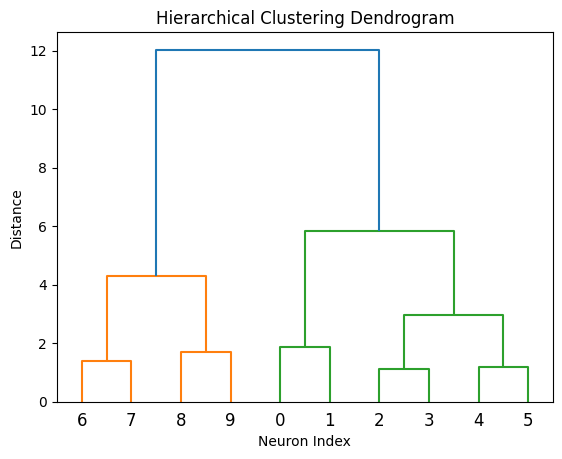

In [51]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(weights_pca, method='ward')
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Neuron Index")
plt.ylabel("Distance")
plt.show()


In [52]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(weights_pca)
print("DBSCAN Cluster Labels:", labels)


DBSCAN Cluster Labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


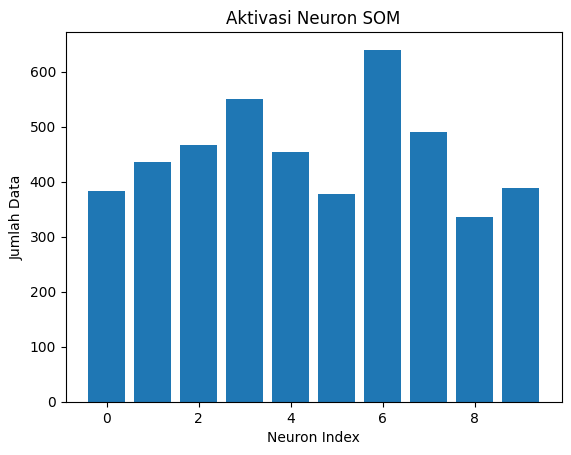

In [53]:
activations = np.zeros(m)
for x in X_pca:
    activations[som_pca.hitung_bmu(x)] += 1

plt.bar(range(m), activations)
plt.title("Aktivasi Neuron SOM")
plt.xlabel("Neuron Index")
plt.ylabel("Jumlah Data")
plt.show()


C:\Users\lmaos\AppData\Local\Temp\ipykernel_14508\2523802800.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(final_clusters))  # Warna untuk setiap cluster


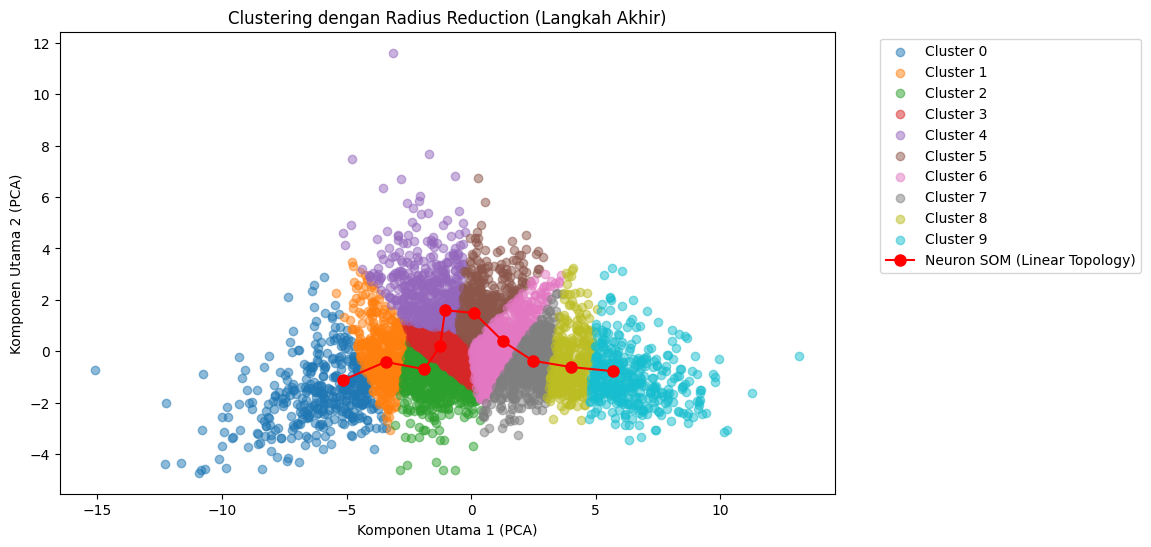

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter Radius Reduction
initial_radius = 4  # Radius awal
final_radius = 0.5  # Radius akhir
steps = 10          # Jumlah langkah reduksi radius

# Cluster storage
radius_clusters = []

# Generate clusters based on radius reduction
for step in range(steps):
    # Hitung radius saat ini
    current_radius = initial_radius * ((final_radius / initial_radius) ** (step / (steps - 1)))

    # Tentukan cluster berdasarkan radius
    clusters = {}
    for idx, weight in enumerate(weights_pca):
        clusters[idx] = []
        for i, x in enumerate(X_pca):
            # Hitung BMU
            bmu = som_pca.hitung_bmu(x)
            # Masukkan data ke dalam cluster jika berada dalam radius
            if abs(idx - bmu) <= current_radius:
                clusters[idx].append(i)

    radius_clusters.append(clusters)

# Plot hasil clustering pada radius terakhir
final_clusters = radius_clusters[-1]  # Cluster terakhir setelah radius minimal
colors = plt.cm.get_cmap("tab10", len(final_clusters))  # Warna untuk setiap cluster

plt.figure(figsize=(10, 6))

# Plot setiap cluster
for cluster_id, indices in final_clusters.items():
    cluster_points = X_pca[indices]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', color=colors(cluster_id), alpha=0.5)

# Plot neuron SOM
plt.plot(weights_pca[:, 0], weights_pca[:, 1], 'r-o', label="Neuron SOM (Linear Topology)", markersize=8)

plt.title("Clustering dengan Radius Reduction (Langkah Akhir)")
plt.xlabel("Komponen Utama 1 (PCA)")
plt.ylabel("Komponen Utama 2 (PCA)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Silhouette Score for K-Means clustering on SOM: 0.35637126786801715


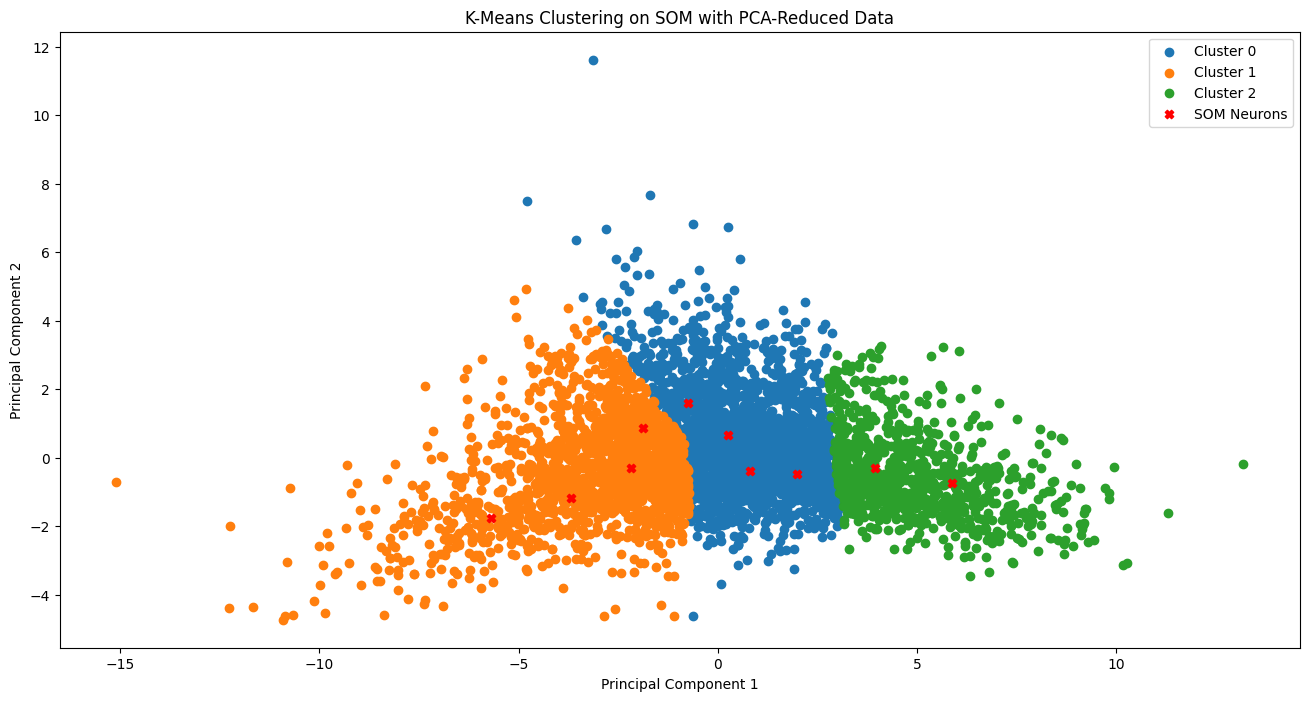

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# K-Means Clustering on SOM weights
num_clusters = 3  # Tentukan jumlah cluster yang diinginkan
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(weights_pca)

# Assign each neuron to a cluster
neuron_clusters = kmeans.labels_

# Assign each data point to a cluster based on its BMU
data_clusters = np.array([neuron_clusters[som_pca.hitung_bmu(x)] for x in X_pca])

# Silhouette Score for clustering evaluation
silhouette_avg = silhouette_score(X_pca, data_clusters)
print("Silhouette Score for K-Means clustering on SOM:", silhouette_avg)

# Visualization
plt.figure(figsize=(16, 8))
for cluster in range(num_clusters):
    cluster_points = X_pca[data_clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    
# Highlight SOM neuron positions
plt.scatter(weights_pca[:, 0], weights_pca[:, 1], c='red', label='SOM Neurons', marker='X')

plt.title('K-Means Clustering on SOM with PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


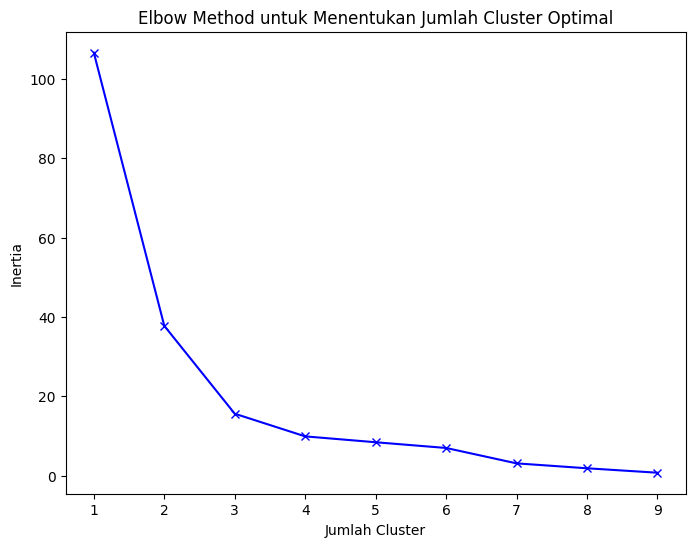

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(weights_pca)  # Menggunakan bobot neuron SOM
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster Optimal')
plt.show()


###Evaluasi 1

In [ ]:
from sklearn.metrics import silhouette_score
# Hitung Silhouette Score dengan label yang sesuai
silhouette_avg = silhouette_score(X_pca, y_train.values)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: -0.08070095881673511


In [17]:
qe = som_pca.quantization_error(X_pca)
te = som_pca.topographic_error(X_pca)

print("Quantization Error (QE):", qe)
print("Topographic Error (TE):", te)

Quantization Error (QE): 1.153818919039071
Topographic Error (TE): 0.05459770114942529


In [ ]:
map_size = (6, 1)  # 6 neurons in 1 row (linear SOM)

weights_pca = som_pca.w  # weights_pca seharusnya berbentuk (6, 1)

# Hitung beberapa metrik menggunakan somperf
print('Topographic Product =', topographic_product(rectangular_topology_dist(map_size), weights_pca))
print('Neighborhood Preservation =', neighborhood_preservation(1, weights_pca, X_pca))
print('Trustworthiness =', trustworthiness(1, weights_pca, X_pca))

Topographic Product = -0.007596293310410708
Neighborhood Preservation = -1.3795012769871318


###Tuning

In [ ]:
# import optuna
# import numpy as np
# from sklearn.metrics import silhouette_score

# # Pastikan class SOMlinier sudah didefinisikan sebelumnya dengan metode quantization_error() dan topographic_error()

# # Fungsi objektif untuk optimasi Optuna
# def objective(trial):
#     # Tuning parameter
#     m = trial.suggest_int('m', 5, 20)           # Jumlah neuron
#     R = trial.suggest_int('R', 1, 5)            # Radius
#     alpha0 = trial.suggest_float('alpha0', 0.01, 0.5)  # Learning rate
#     tau = trial.suggest_int('tau', 100, 1000)   # Konstanta peluruhan
#     n_iterations = trial.suggest_int('n_iterations', 500, 2000)  # Iterasi pelatihan
    
#     # Inisialisasi dan latih SOM dengan parameter yang dipilih
#     som = SOMlinier(m=m, fitur=X_train_np.shape[1], R=R, alpha=alpha0, tau=tau)
#     som.train(X_train_np, n_iterations)

#     # Hitung QE, TE, dan Silhouette Score
#     qe = som.quantization_error(X_train_np)
#     te = som.topographic_error(X_train_np)

#     # Hitung BMU untuk setiap data dan hitung Silhouette Score
#     bmu_indices = np.array([som.hitung_bmu(x) for x in X_train_np])
#     silhouette = silhouette_score(X_train_np, bmu_indices)
    
#     # Kombinasikan ketiga metrik dengan bobot tertentu
#     # Di sini, kita meminimalkan QE dan TE, tetapi memaksimalkan Silhouette Score
#     # Jadi kita gunakan negatif Silhouette Score (karena Optuna meminimalkan nilai)
#     combined_score = (0.4 * qe) + (0.4 * te) - (0.2 * silhouette)

#     return combined_score

# # Buat study untuk optimasi
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)

# # Cetak hasil terbaik
# print("Best parameters for SOM:", study.best_params)
# print("Best combined score:", study.best_value)
